In [14]:
# Python built-in modules
import sys
import os.path
import json
import subprocess
import shlex
from collections import Counter

# %pip install pandas
import pandas as pd

# %pip install numpy
import numpy as np

# %pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# %pip install scipy
from scipy.spatial.distance import cosine

# %pip install matplotlib
import matplotlib.pyplot as plt

# %pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
# Read material to pandas dataframe format
reviews_df = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')
print(reviews_df)

                                                Review  Liked
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
..                                                 ...    ...
995  I think food should have flavor and texture an...      0
996                           Appetite instantly gone.      0
997  Overall I was not impressed and would not go b...      0
998  The whole experience was underwhelming, and I ...      0
999  Then, as if I hadn't wasted enough of my life ...      0

[1000 rows x 2 columns]


In [3]:
# Initialize SentiStrength
senti_strength_path = "./sentistrength/SentiStrength.jar"
language_folder_path = "./sentistrength/SentiStrength_Data/"

# Check that paths are correct
if not os.path.isfile(senti_strength_path):
    print("SentiStrength not found at: ", senti_strength_path)
if not os.path.isdir(language_folder_path):
    print("SentiStrength data folder not found at: ", language_folder_path)

# Returns SentiStrength sentiment score for the given string
def rate_sentiment(sentiString):
    # Open a subprocess using shlex to get the command line string into the correct args list format.
    p = subprocess.Popen(shlex.split("java -jar '" + senti_strength_path + "' stdin sentidata '" + language_folder_path + "'"),
                         stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # Communicate via stdin the string to be rated. Note that all spaces are replaced with +.
    # Can't send string in Python 3, must send bytes.
    b = bytes(sentiString.replace(" ","+"), 'utf-8')
    stdout_byte, stderr_text = p.communicate(b)
    stdout_text = stdout_byte.decode("utf-8")
    # Remove the tab spacing between the positive and negative ratings. e.g. "1    -5" -> "1 -5"
    stdout_text = stdout_text.rstrip().replace("\t"," ")
    return stdout_text

# Convert the score from 1 -5 to binary: 0 for dislike, 1 for like
# "Neutral" score, for example -2 2, is cast as 0
def score_to_binary(score_original):
    binary_score = score_original.split(' ')
    binary_score = list(binary_score)
    binary_score = [1 if int(binary_score[i]) > abs(int(binary_score[i+1])) else 0 for i in range(0, len(binary_score), 3)]
    return binary_score[0]

In [4]:
# SentiStrength usage example

example_sentence = "'What a lovely day!'"

rated = rate_sentiment(example_sentence)
converted = score_to_binary(rated)

print("Rating the sentence:")
print(example_sentence)
print("\nRated by SentiStrength:")
print(rated)
print("\nRating converted to 0 for dislike / 1 for like:")
print(converted)

Rating the sentence:
'What a lovely day!'

Rated by SentiStrength:
3 -1

Rating converted to 0 for dislike / 1 for like:
1


In [7]:
""" 1.
Use initially SentiStrength SentiStrength - sentiment strength detection in short texts - sentiment analysis,
opinion mining (http://sentistrength.wlv.ac.uk/) implementation of sentiment, which provides negative and positive
sentiment score, compute Pearson correlation between this constructed sentiment polarity and the annotation.
"""

review_column = reviews_df["Review"]
liked_column = reviews_df["Liked"]

sentistrength_sentiments = []

for row in review_column:
    rated_sentiment = rate_sentiment(row)
    converted_sentiment = score_to_binary(rated_sentiment)
    sentistrength_sentiments.append(converted_sentiment)

pearson_corr_coeff = np.corrcoef(sentistrength_sentiments, liked_column)
print("Pearson correlation coefficient matrix:\n", pearson_corr_coeff)
print("\nPearson correlation between textblob sentiment and review liked score:\n", pearson_corr_coeff[1][0])

Pearson correlation coefficient matrix:
 [[1.         0.61844668]
 [0.61844668 1.        ]]

Pearson correlation between textblob sentiment and review liked score:
 0.618446679812491


In [8]:
""" 2.
Repeat this process when considering the correlation of the positive class alone
and the correlation of the negative class alone.

"""

# Calculate overall cosine similarity
cosine_similarity = cosine(sentistrength_sentiments, liked_column)
print("Overall cosine similarity:", cosine_similarity)


# Calculate cosine similarity of positive class alone
positive_sentistrength_sentiments = []
positive_corresponding_liked_column = []

for index, rating in enumerate(sentistrength_sentiments):
    if rating == 1:
        positive_sentistrength_sentiments.append(sentistrength_sentiments[index])
        positive_corresponding_liked_column.append(liked_column[index])

positive_cosine_similarity = cosine(positive_sentistrength_sentiments, positive_corresponding_liked_column)
print("Positive cosine similarity:", positive_cosine_similarity)


# Calculate cosine similarity of negative class alone
negative_sentistrength_sentiments = []
negative_corresponding_liked_column = []

for index, rating in enumerate(sentistrength_sentiments):
    if rating == 0:
        negative_sentistrength_sentiments.append(sentistrength_sentiments[index])
        negative_corresponding_liked_column.append(liked_column[index])

# Undefined, division with 0 happens when one of the vectors of cosine similarity is all zeroes
negative_cosine_similarity = cosine(negative_sentistrength_sentiments, negative_corresponding_liked_column)
print("Negative cosine similarity:", negative_cosine_similarity)

Overall cosine similarity: 0.19454820209239165
Positive cosine similarity: 0.09379592739503684
Negative cosine similarity: 0


c:\Python310\lib\site-packages\scipy\spatial\distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [11]:
# TODO Fix to fit new task

""" 3.
Now we want to test the correlation with respect to some stylistic aspects of the review. Write a script that
estimate the number of personal pronouns and number of adjectives and number of adverbs using part-of-speech
tagger of your choice. Compute both the cosine similarity between each of the above attributes (number of
pronouns, number of adjectives, number of adverbs) and the annotation.


Old task
Now we want to test the correlation with respect to some stylistic aspects of the review. Write a script that estimate
the length of the review in terms of number of characters. Compute both the Pearson correlation and the cosine similarity
between the Review length and the annotations.
"""

# Add review_length column to dataframe
reviews_df['Length'] = reviews_df['Review'].str.len()
review_length_column = reviews_df["Length"]
print("Length column added to the dataframe:\n")
print(reviews_df, "\n\n")

# Calculate Pearson correlation between review length and review liked score
pearson_corr_coeff_length = np.corrcoef(review_length_column, liked_column)
print("Pearson correlation between review length and review liked score:\n", pearson_corr_coeff_length[1][0])

# Calculate cosine similarity between review length and review liked score
cosine_similarity_length = cosine(review_length_column, liked_column)
print("\nCosine similarity between review length and review liked score:\n", cosine_similarity_length)

Length column added to the dataframe:

                                                Review  Liked  Length
0                             Wow... Loved this place.      1      24
1                                   Crust is not good.      0      18
2            Not tasty and the texture was just nasty.      0      41
3    Stopped by during the late May bank holiday of...      1      87
4    The selection on the menu was great and so wer...      1      59
..                                                 ...    ...     ...
995  I think food should have flavor and texture an...      0      66
996                           Appetite instantly gone.      0      24
997  Overall I was not impressed and would not go b...      0      50
998  The whole experience was underwhelming, and I ...      0      91
999  Then, as if I hadn't wasted enough of my life ...      0     134

[1000 rows x 3 columns] 


Pearson correlation between review length and review liked score:
 -0.07528475029141278

Cosi

In [9]:
# TODO Fix to fit new task

""" 4.
We want to test the hypothesis that the opinion of about the restaurant is constructed according to Price, Quality of
food served in the restaurant, and friendly staff. Suggest a script that allows you to identify Review that are
more focused on price, quality of food, friendly staff. You may consider a set of keywords that are most suitable
to each category and then use simple string matching to match this effect. For each category, generate a binary vector
indicating whether the given review focuses on the corresponding category.


Old task
We want to test the hypothesis that the opinion of about the restaurant is constructed according to Price, Quality of
food, Quantity of the food, and location of restaurant. Suggest a script that allows you to identify Review that are
more focused on price, quality of food, quantity of food and location of restaurant. You may consider a set of keywords
that are most suitable to each category and then use simple string matching to match this effect. For each category,
generate a binary vector indicating whether the given review focuses on the corresponding category.
"""

def any_keywords_in_string(keywords, string):
    if any(keyword in string for keyword in keywords):
        return(1)
    else:
        return(0)

def print_pearson(first_thing_name, second_thing_name, pearson_corr_coeff):
    print(f"Pearson correlation between {first_thing_name} and {second_thing_name}:\n {pearson_corr_coeff[1][0]}")

def print_cosine_similarity(first_thing_name, second_thing_name, cosine_similarity):
    print(f"Cosine similarity between {first_thing_name} and {second_thing_name}:\n {cosine_similarity}")


f = open("keywords.json","r")
keywords = json.loads(f.read())
f.close()

review_column = reviews_df["Review"]
liked_column = reviews_df["Liked"]
price_focus = []
quality_focus = []
quantity_focus = []
location_focus = []

for column in review_column:
    price_focus.append(any_keywords_in_string(keywords["price"], column))
    quality_focus.append(any_keywords_in_string(keywords["quality"], column))
    quantity_focus.append(any_keywords_in_string(keywords["quantity"], column))
    location_focus.append(any_keywords_in_string(keywords["location"], column))



In [10]:
# TODO Fix to fit new task

""" 5.
Estimate the correlation using Pearson correlation between each vector category and the data annotation. 

Old task
Estimate the correlation using Pearson correlation and cosine similarity between each vector category and the data annotation.
"""

pearson_corr_coeff_price = np.corrcoef(price_focus, liked_column)
pearson_corr_coeff_quality = np.corrcoef(quality_focus, liked_column)
pearson_corr_coeff_quantity = np.corrcoef(quantity_focus, liked_column)
pearson_corr_coeff_location = np.corrcoef(location_focus, liked_column)

cosine_similarity_price = 1 - cosine(price_focus, liked_column)
cosine_similarity_quality = 1 - cosine(quality_focus, liked_column)
cosine_similarity_quantity = 1 - cosine(quantity_focus, liked_column)
cosine_similarity_location = 1 - cosine(location_focus, liked_column)

print_pearson("price","liked score", pearson_corr_coeff_price)
print_cosine_similarity("price","liked score", cosine_similarity_price)


print("")
print_pearson("quantity","liked score", pearson_corr_coeff_quantity)
print_cosine_similarity("quantity","liked score", cosine_similarity_quantity)


print("")
print_pearson("quality","liked score", pearson_corr_coeff_quality)
print_cosine_similarity("quality","liked score", cosine_similarity_quality)

print("")
print_pearson("location","liked score", pearson_corr_coeff_location)
print_cosine_similarity("location","liked score", cosine_similarity_location)


Pearson correlation between price and liked score:
 4.312833250894071e-18
Cosine similarity between price and liked score:
 0.054772255750516585

Pearson correlation between quantity and liked score:
 0.03867842532010902
Cosine similarity between quantity and liked score:
 0.11931175180026088

Pearson correlation between quality and liked score:
 0.060038704084636296
Cosine similarity between quality and liked score:
 0.14920076931845028

Pearson correlation between location and liked score:
 0.0
Cosine similarity between location and liked score:
 0.08944271909999157


In [ ]:
""" 6.
We want to revisit the construction of the categories in 4). Instead of string matching, use the semantic
similarity in the following way. Calculate the Wu and Palmer similarity between “price” and the Review (using
the sentence-to-sentence similarity as in labs), repeat this process for the other three categories by suggestion
a representative keyword (s) that will be used to calculate sentence-to-sentence similarity score.
"""

In [ ]:
""" 7.
We want to test another approach for computing the categories by using the empath categories embedding. For this
purpose, re-visit the naming of the empath-categories in GitHub - Ejhfast/empath-client: analyze text with empath
(https://github.com/Ejhfast/empath-client) and select those that might be linked to Price, Quality, Staff friendship.
Write a code that allows you to determine appropriate categories from this embedding and then calculate the correlation
score.  Alternative to manual scrutinization of the Empath categories, you may also generate an empath category
embedding for the keyword “price”, “food quality”, “friendly staff”, and then compute cosine similarity between the
Review embedding vector and each of the above four embedding vectors, so that the one that yields the highest similarity
score will be considered as the one that best represents the underlined category.
"""

Number of misclassified ratings:
191 

Number of word tokens after preprocessing:
1057 

Word tokens after preprocessing (print truncated to first 50 elements):
['potatoes', 'like', 'rubber', 'could', 'tell', 'make', 'ahead', 'time', 'keep', 'warmer', 'service', 'prompt', 'cashier', 'care', 'ever', 'say', 'still', 'end', 'wayyy', 'overprice', 'highly', 'recommend', 'burrittos', 'blah', 'perform', 'like', 'final', 'blow', 'redeem', 'quality', 'restaurant', 'inexpensive', 'deal', 'good', 'enough', 'would', 'drag', 'establishment', 'thing', 'like', 'prime', 'rib', 'dessert', 'section', 'side', 'greek', 'salad', 'greek', 'dress', 'tasty'] 

Histogram of the 10 most common words:


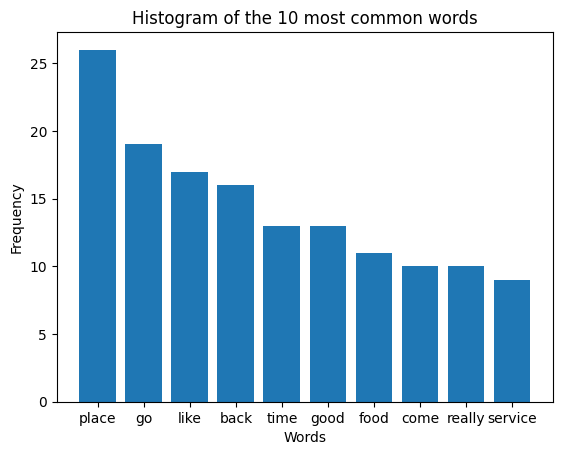

In [15]:
""" 8.
We want to further emphasize on misclassified reviews. For this purpose, concatenate all reviews for which the
sentiment score is positive while the annotation is zero and those for which the sentiment is zero while the
annotation is 1. Construct the Wordcloud of this dataset. Write a histogram showing the 10 most common wordings
in this dataset. Comment on the findings.
"""

# Collect misclassified ratings
misclassified_reviews = []

for index, row in enumerate(review_column):
    rated_sentiment = rate_sentiment(row)
    converted_sentiment = score_to_binary(rated_sentiment)

    if converted_sentiment != liked_column[index]:
        misclassified_reviews.append(row)

print("Number of misclassified ratings:")
print(len(misclassified_reviews), "\n")


# Preprocessing
def pre_process(doc_string):
    stopwords = list(set(nltk.corpus.stopwords.words('english')))
    sentences = sent_tokenize(doc_string)
    tokens = []

    for sentence in sentences:
        words = word_tokenize(sentence.lower())

        # TODO Do we want stemming?
        # words = [SnowballStemmer("english").stem(word) for word in words]

        # TODO Lots of misspelled words -> misspelling correction?

        words = [WordNetLemmatizer().lemmatize(word, pos="v") for word in words]

        # Leave out numbers and stopwords
        words = [
            word for word in words
            if word.isalpha()
            and word not in stopwords
        ]
        tokens.extend(words)

    return tokens


misclassified_reviews_preprocessed = pre_process(' '.join(misclassified_reviews))

print("Number of word tokens after preprocessing:")
print(len(misclassified_reviews_preprocessed), "\n")

print("Word tokens after preprocessing (print truncated to first 50 elements):")
print(misclassified_reviews_preprocessed[:50], "\n")


# Collect 10 most common words
most_common_words = Counter(misclassified_reviews_preprocessed).most_common(10)

# Parse the generated tuples into two different arrays
words = [word for word, _ in most_common_words]
counts = [counts for _, counts in most_common_words]

# Plot the words and their frequency
print("Histogram of the 10 most common words:")
plt.bar(words, counts)
plt.title("Histogram of the 10 most common words")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()



# TODO Word cloud



In [16]:
""" 9.
Now we would like to build a machine learning model for sentiment analysis that takes into account the ambiguous
cases identified in 9). For this purpose, write and script and review the preprocessing and stopword list to not
discard relevant information in the context of sentiment analysis (e.g., avoid discarding negation cues, adjectives
that subsumes polarity and apostrophes, lower-case as capitalization brings emotion,..), then use TfIdfVectorizer
with a maximum feature set of 500, minimum 2 repetition and no more than 60% of word repetition across sentences.
Build this model for one dataset using randomly selected 70% training and 30% testing. Report the classification
accuracy.
"""


# TODO preprocessing: "avoid discarding negation cues, adjectives that subsumes polarity and apostrophes,
# lower-case as capitalization brings emotion,.."
# TODO "minimum 2 repetition and no more than 60% of word repetition across sentences"
# TODO How to evaluate model?

TFIDF = TfidfVectorizer(max_features=500)

training_data, testing_data = train_test_split(misclassified_reviews, test_size=0.3)

tfidf_model = TFIDF.fit(training_data)

tfidf_predicted_vectors = tfidf_model.transform(testing_data)

# print(tfidf_predicted_vectors)

df2 = pd.DataFrame(tfidf_predicted_vectors.toarray().transpose(),
                   index=TFIDF.get_feature_names_out())
print(df2)




                  0    1    2         3    4    5    6    7    8    9   ...  \
20          0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
30s         0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
85          0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
about       0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
above       0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...   
writing     0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
wrong       0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
yellowtail  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
you         0.235904  0.0  0.0  0.219447  0.0  0.0  0.0  0.0  0.0  0.0  ...   
your        0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                  48   49   50        51        52 

In [ ]:
""" 10.
Use Glove embedding instead of TfidfVectorizer, see GloVe: Global Vectors for Word Representation
(https://nlp.stanford.edu/projects/glove/). Use the Glove embedding as feature vectors and test the performance in
the original data (30% test data) and report the classification accuracy on the other two datasets. Comment on the
limitations of the approach
"""




In [ ]:
""" 11.
Identify appropriate literature to comment on your findings and methodology.
"""


